<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# INSTALL DEPENDENCIES
# Uncomment and run only once.
# !pip install -U matplotlib numpy pandas scikit-learn scipy tensorflow pyclustering

In [2]:
# IMPORTS AND GLOBAL CONSTANTS

# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
import datetime, os
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt

##MAIN PROGRAM VARIABLES##
##(0): dataset: np array of strings
##(1): dataframe: original dataset in its primal form
##(2): ratings_num_df: new dataframe storing the number of rated items per unique user
##(3): ratings_span_df: new dataframe storing the timespan in days for each user
##(4): minimum_ratings - maximum_ratings => ratings_df=> (i) final_df

# Constants
DATASET_FILE_PATH = "./Dataset.npy"
#Define the figures path
FIGURES_PATH = "figures"
os.makedirs(FIGURES_PATH, exist_ok=True)
# #Define the data folder path
DATAFOLDER_PATH = "datafile"
os.makedirs(DATAFOLDER_PATH, exist_ok=True)
#Load the dataset in an np array
#datafile = "datafile/Dataset.npy"
#dataset=np.load(dataset)

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive/')
  DATASET_FILE_PATH = "/content/drive/My Drive/Colab Notebooks/Dataset.npy"


Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
dataset: np.ndarray = np.load(DATASET_FILE_PATH)
# delete this when we fix performance
dataset = dataset[:500000]

In [4]:
#Define the splitter lambda function in order to tokenize the initial string data.
splitter = lambda s: s.split(",")
#Apply the splitter lambda function on the string np array
dataset = np.array([splitter(x) for x in dataset])
#Set the pickle file for storing the initial dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "dataframe.pkl")
#Check the existence of the specified file.
if os.path.exists(pickle_file):
    #Load the pickle file
    dataframe = pd.read_pickle(pickle_file)
else:
    #Create the dataframe object.
    dataframe = pd.DataFrame(dataset, columns=['User','Movie','Rating','Date'])
    #Convert the string elements of the "Users" series into integers
    dataframe["User"] = dataframe["User"].apply(lambda s:np.int64(s.replace("ur","")))
    #Convert the string elements of the "Movies" series into integers
    dataframe["Movie"] = dataframe["Movie"].apply(lambda s:np.int64(s.replace("tt","")))
    #Convert the string elements of the "Ratings" series into integers
    dataframe["Rating"] = dataframe["Rating"].apply(lambda s:np.int64(s))
    #Convert the string element of "Dates" series into datetime Object
    dataframe["Date"] = pd.to_datetime(dataframe["Date"])
    dataframe.to_pickle(pickle_file)

In [5]:
#Get the unique users in the dataset.
users = dataframe["User"].unique()
#Get the number of unique users
users_num = len(users)
#Get the unique movie items in the dataset.
movies = dataframe["Movie"].unique()
#Get the number of unique movies
movies_num = len(movies)
#Get the total number of existing ratings.
ratings_num = dataframe.shape[0]
#Report the number of unique Users and Movies in the dataset
print("INITIAL DATASET: {0} number of unique users and {1} of unique movies".format(users_num, movies_num))
#Report the total number of existing ratings in the dataset
print("INITIAL DATASET: {} total number of existing ratings".format(ratings_num))

INITIAL DATASET: 218513 number of unique users and 76828 of unique movies
INITIAL DATASET: 500000 total number of existing ratings


In [6]:
#Define the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_num_df.pkl")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file):
    #Load the pickle file
    ratings_num_df = pd.read_pickle(pickle_file)
else:
    ratings_num_df = dataframe.groupby("User")["Rating"].count().sort_values(ascending=False).reset_index(name="ratings_num")
    #Save the previously created dataframe to pickle
    ratings_num_df.to_pickle(pickle_file)

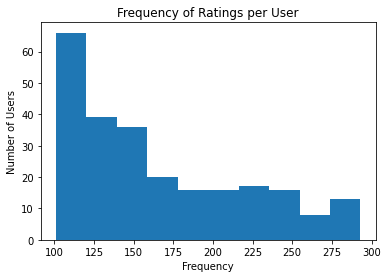

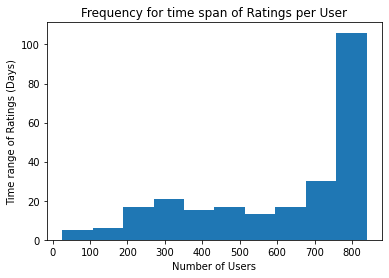

In [7]:
#Set the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_span_df.pkl")
if os.path.exists(pickle_file):
    ratings_span_df = pd.read_pickle(pickle_file)
else:
    ratings_span_df = dataframe.groupby("User")["Date"].apply(lambda date: max(date)-min(date)).sort_values(ascending=False).reset_index(name="ratings_span")
    ratings_span_df.to_pickle(pickle_file)
#Create a new ratings dataframe by joining the previously defined dataframe
ratings_df = ratings_num_df.join(ratings_span_df.set_index("User"),on="User")
ratings_df["ratings_span"]=ratings_df["ratings_span"].dt.days
#Set the threshold values for the minimum and maximum number of Ratings per user
minimum_ratings = 100
maximum_ratings = 300
#Discard all users that do not pertain to the previous range of ratings
reduced_ratings_df = ratings_df.loc[(ratings_df["ratings_num"] >= minimum_ratings) & (ratings_df["ratings_num"] <= maximum_ratings)]

#Generate the frequency histogram for the number of ratings per user
reduced_ratings_df["ratings_num"].plot(kind='hist', title='Frequency of Ratings per User', xticks=range(minimum_ratings, maximum_ratings+1, 25))
plt.xlabel('Frequency')
plt.ylabel('Number of Users')

plt.show()
#Generate the frequency histogram for the time span of ratings per user
reduced_ratings_df["ratings_span"].plot(kind='hist', title='Frequency for time span of Ratings per User')
plt.xlabel('Number of Users')
plt.ylabel('Time range of Ratings (Days)')

plt.show()



                                                                                    

In [8]:
#Get the final dataframe by excluding all users whose ratings fall outside the prespecified range
final_df = dataframe.loc[dataframe["User"].isin(reduced_ratings_df["User"])].reset_index()
#Drop the links (indices) to the original table
final_df = final_df.drop("index", axis=1)
#Get the unique users and items in the final dataframe along with the final number of ratings
final_users = final_df["User"].unique()
final_movies = final_df["Movie"].unique()
final_users_num = len(final_users)
final_movies_num = len(final_movies)
final_ratings_num = len(final_df)

#Report the final number of unique users and movies in the dataset
print("REDUCED DATASET: {0} number of unique users and {1} number of unique movies".format(final_users_num, final_movies_num))
#Report the final number of existing ratings in the dataset
print("REDUCED DATASET: {} number of existing ratings in the dataset".format(final_ratings_num))

REDUCED DATASET: 247 number of unique users and 17476 number of unique movies
REDUCED DATASET: 40787 number of existing ratings in the dataset


In [9]:
#We need to reset the users and items IDs in order to be able to construct a network of users and Movies. 
#Users and Movies IDs should be consecutive in the [1..final_users_num] and [1...final_movies_num]
#Initially, we need to acquire the sorted versions of the user and movies
sorted_final_users = np.sort(final_users)
sorted_final_movies = np.sort(final_movies)
#Generate the dictionary of final users as a mapping of the following 
#sorted_final_users --> [0...final_users_num-1]
final_users_dict = dict(zip(sorted_final_users,list(range(0,final_users_num))))
#Generate the dictionary of final items as a mapping of the following
final_movies_dict = dict(zip(sorted_final_movies,list(range(0,final_movies_num))))
#Apply the previously defined dictionary-based maps on the users and movies columns of the final dataframe
final_df["User"] = final_df["User"].map(final_users_dict)
final_df["Movie"] = final_df["Movie"].map(final_movies_dict)
#Get a grouped version of the original dataframe based on the unique final users
users_group_df = final_df.groupby("User")
#Initialize the adjacency matrix which stores the connection status for pair of users in the recommendation network
W = np.zeros((final_users_num, final_users_num))
#Iinitialize the matrix storing the number of commonly rated items for a pair of users
CommonRatings = np.zeros((final_users_num, final_users_num))
#Initialize the matrix of common ratings
#Matrix W will be of size [final_users_num x final_users_num],
#Let U = {u1, u2,...,un} be the final set of users and I = {i1,i2,...,im}
#final set of movies. By considering the function Fi: U -> P(I) where
#P(I) is the powerset of I, Fi(u) returns the subset of items that has been rated by user u. 
#In this context, the edge weight between any given pair of users (u,v) will be computed as:
#
#          |Intersection(Fi(u)),Fi(v))|
#W(u,v) =  -----------------------------
#               |Union(Fi(u),Fi(v))|
#
#
#In order to speed up the construction of the adjacency matrix for the ratings network, 
#construct a dictionary object that will store a set of rated items for each unique user.
user_items_dict = {}
# for user in final_users:
    #print(user)
    # user_index = final_users_dict[user]
    # user_movies = set(users_group_df.get_group(user_index)["Movie"])
    # user_items_dict[user_index] = user_movies
                                                 
# Initialize the dictionary for storing the set of rated items for each user
user_items_dict = {}
# print(final_users_dict)
# print(sorted_final_users)
# print(final_users_dict)
# For each unique user, find the set of movies that they rated
for user in final_users:
    if user in final_users_dict:
        user_index = final_users_dict[user]
        user_movies = set(users_group_df.get_group(user_index)["Movie"])
        user_items_dict[user_index] = user_movies 

In [10]:
user_ids = list(user_items_dict.keys())
user_ids.sort()
#Generate the sorted version of the dictionary
user_items_dict = {user_index:user_items_dict[user_index] for user_index in user_ids}
#Set the pickle file that will store the graph adjacency matrix W.
pickle_file_weights = os.path.join(DATAFOLDER_PATH, "w")
pickle_file_common_ratings = os.path.join(DATAFOLDER_PATH, "common_ratings")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file_weights) & os.path.exists(pickle_file_common_ratings):
    #Load the pickle file
    W = np.load(pickle_file_weights)
    CommonRatings = np.load(pickle_file_common_ratings)
else:
    for source_user in user_items_dict.keys():
        for target_user in user_items_dict.keys():
            intersection_items = user_items_dict[source_user].intersection(user_items_dict[target_user])
            union_items = user_items_dict[source_user].union(user_items_dict[target_user])
            W[source_user, target_user] = len(intersection_items)/len(union_items)
            CommonRatings[source_user, target_user] = len(intersection_items)
    np.save(pickle_file_weights,W)
    np.save(pickle_file_common_ratings,CommonRatings)

In [11]:
W

array([[1.        , 0.04432133, 0.00320513, ..., 0.        , 0.        ,
        0.00444444],
       [0.04432133, 1.        , 0.00440529, ..., 0.        , 0.        ,
        0.00819672],
       [0.00320513, 0.00440529, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.00444444, 0.00819672, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [12]:
CommonRatings

array([[117.,  16.,   1., ...,   0.,   0.,   1.],
       [ 16., 260.,   2., ...,   0.,   0.,   3.],
       [  1.,   2., 196., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 122.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 138.,   0.],
       [  1.,   3.,   0., ...,   0.,   0., 109.]])

In [13]:
final_df

,User,Movie,Rating,Date
0,156,5302,10,2005-01-16
1,65,7716,6,2005-01-16
2,5,8398,7,2005-01-16
3,5,11786,3,2005-01-16
4,87,12708,9,2005-01-16
...,...,...,...,...
40782,192,15941,6,2007-05-05
40783,192,15493,3,2007-05-05
40784,192,16041,7,2007-05-05
40785,53,268,7,2007-05-05


#Δημιουργούμε έναν πίνακα χρηστών - ταινιών 
(οι χρήστες βρίσκονται στις γραμμές και οι ταινίες στις στήλες του πίνακα)
όπου τα στοιχεία του πίνακα είναι από 1 - 10. Εάν ο χρήστης δεν έχει αξιολογήσει την ταινία,
η αξιολόγηση που θα ανατεθεί είναι 0.

In [14]:
# Create a pivot table of user-movie ratings
ratings_matrix = final_df.pivot_table(index='User', columns='Movie', values='Rating')
ratings_matrix = ratings_matrix.fillna(0)

In [15]:
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,17466,17467,17468,17469,17470,17471,17472,17473,17474,17475
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

Θέλουμε να δημιουργήσουμε τον πίνακα βαρών "λ" των χρηστών. Τον πίνακα αξιολογήσεων δηλαδή όπου η τιμή της αξιολόγησης είναι 1 εάν η ταινία έχει αξιολογηθεί από τον χρήστη ή 0 εάν δεν έχει αξιολογηθεί

In [17]:
# Threshold
threshold = 1

# Transform to binary
binary_matrix = np.where(ratings_matrix >= threshold, 1, 0)

In [18]:
binary_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
# Convert the matrix to a numpy array
matrix_array = ratings_matrix.to_numpy()

# Create a dictionary that maps each row of the matrix to its index
# matrix_dict = {tuple(row): i for i, row in enumerate(matrix_array)}

# ***Αλγόριθμοι Ομαδοποίησης Δεδομένων***

**Χρήση της Weighted Euclidean Distance**

In [20]:
from scipy.spatial.distance import pdist, cdist
import numpy as np

from scipy.sparse import csr_matrix

def pairwise_weighted_euclidean_distance(X, weights):
    # Find the indices of the rated movies for each pair of users
    rated_movies = (weights_sparse.T @ weights_sparse) > 0

    # Select only the rated movies for each pair of users
    X_rated = X_sparse[:, rated_movies]
    
    # Calculate the pairwise weighted Euclidean distance between 
    #users who have rated the same movie
    return cdist(X, metric='euclidean')

def kmeans_pairwise_weighted_euclidean(X, weights, k, max_iters=2):

    n, m = X.shape
    centroids = X[np.random.choice(n, k, replace=False)]
    distances = pairwise_weighted_euclidean_distance(X, weights)
    for i in range(max_iters):
        # Assign points to clusters
        cluster_assignments = np.argmin(distances, axis=1)

        # Recalculate cluster centroids
        for j in range(k):
            cluster_points = X[cluster_assignments == j]
            if len(cluster_points) > 0:
                centroids[j] = np.average(cluster_points, axis=0)

        # Update distances to centroids
        distances = pairwise_weighted_euclidean_distance(X, weights)

    return cluster_assignments, centroids


In [21]:
# Calculate the weighted Euclidean distance matrix
D = np.zeros((ratings_matrix.shape[0], ratings_matrix.shape[0]))

for i in range(ratings_matrix.shape[0]):
    for j in range(i, ratings_matrix.shape[0]):
        d = np.sqrt(np.sum(binary_matrix[i,:]*binary_matrix[j,:] * (ratings_matrix.iloc[i,:] - ratings_matrix.iloc[j,:])**2))
        D[i,j] = d
        D[j,i] = d


In [22]:
D

array([[0.        , 6.78232998, 5.        , ..., 0.        , 0.        ,
        3.        ],
       [6.78232998, 0.        , 5.09901951, ..., 0.        , 0.        ,
        3.16227766],
       [5.        , 5.09901951, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.        , 3.16227766, 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Clustering users using K-means
 We want to start by creating the symmetric D matrix which contains the pairwise weighted Euclidean distance for every pair of users.
 We calculate the distance between each user using 
*   dist_{u,v}=\sum_{k=1}^{n}\sqrt{|R_{u}(k) - R_{v}(k)|λ_{u}(k)λ_{v}(k)}




In [23]:
# Calculate the pairwise weighted Euclidean distance matrix
n = ratings_matrix.shape[0]
n = 100
Dist_euclidean = np.zeros((n, n))
for i in range(n):
  for j in range(i, n):
      d = np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * (ratings_matrix.loc[i,:] - ratings_matrix.loc[j,:])**2))
      Dist_euclidean[i,j] = d
      Dist_euclidean[j,i] = d

In [24]:
df_euclidean = pd.DataFrame(Dist_euclidean)
df_euclidean

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.00000,6.782330,5.00000,4.000000,2.000000,8.246211,6.082763,6.708204,2.828427,4.472136,...,8.366600,6.324555,1.000000,6.082763,11.045361,0.0,6.000000,2.000000,6.633250,0.0
1,6.78233,0.000000,5.09902,2.449490,3.316625,12.806248,13.820275,4.242641,10.816654,7.416198,...,11.958261,9.949874,9.643651,9.165151,13.304135,5.0,7.416198,3.741657,5.099020,0.0
2,5.00000,5.099020,0.00000,0.000000,1.000000,0.000000,6.000000,2.000000,0.000000,4.000000,...,2.000000,3.000000,0.000000,2.000000,3.000000,3.0,0.000000,3.000000,3.000000,0.0
3,4.00000,2.449490,0.00000,0.000000,2.000000,5.830952,4.000000,5.291503,0.000000,3.872983,...,3.464102,4.000000,3.000000,6.000000,6.782330,0.0,4.690416,1.732051,2.645751,0.0
4,2.00000,3.316625,1.00000,2.000000,0.000000,1.414214,4.000000,1.000000,3.000000,2.000000,...,0.000000,3.000000,2.236068,1.414214,4.242641,0.0,4.358899,3.162278,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.00000,5.000000,3.00000,0.000000,0.000000,5.385165,5.000000,0.000000,7.615773,2.449490,...,4.000000,5.099020,7.000000,3.605551,10.535654,0.0,0.000000,1.000000,0.000000,0.0
96,6.00000,7.416198,0.00000,4.690416,4.358899,10.049876,8.485281,9.110434,0.000000,2.645751,...,7.745967,8.544004,1.000000,4.898979,7.071068,0.0,0.000000,8.660254,8.000000,0.0
97,2.00000,3.741657,3.00000,1.732051,3.162278,4.472136,3.162278,5.744563,1.000000,2.828427,...,5.000000,6.082763,1.414214,6.082763,11.401754,1.0,8.660254,0.000000,2.000000,0.0
98,6.63325,5.099020,3.00000,2.645751,1.000000,5.477226,6.782330,5.477226,1.414214,4.358899,...,5.291503,8.124038,3.605551,7.549834,10.392305,0.0,8.000000,2.000000,0.000000,0.0


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [25]:
from sklearn.cluster import KMeans
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(Dist_euclidean)

# Get the cluster labels
labels_euclidean = kmeans.labels_

# Print the labels
print(labels_euclidean)

[3 0 1 2 2 0 3 3 2 2 2 1 2 2 2 4 0 3 0 2 3 3 4 0 3 3 2 1 1 1 1 4 4 2 0 2 1
 0 1 0 0 2 1 1 1 4 2 3 0 3 1 0 0 1 3 0 1 3 0 3 3 1 2 3 3 2 0 3 3 3 0 4 2 2
 0 1 0 4 1 3 3 2 3 3 3 1 1 3 1 4 3 0 2 0 0 2 3 2 2 1]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster the users, by using a custom 
dist = 1 - np.abs(np.sum(R_u*R_v*weights_u*weights_l)/(np.sqrt(R^2_u*weights_u*weights_l)*np.sqrt(R^2_v*weights_u*weights_l)

---



In [26]:
# Calculate the pairwise weighted Cosine distance matrix
n = ratings_matrix.shape[0]
n = 100
Dist_cosine = np.zeros((n, n))
for i in range(n):
  for j in range(i, n):
      d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))
      Dist_cosine[i,j] = d
      Dist_cosine[j,i] = d

<ipython-input-26-1eb834a4b67d>:7: RuntimeWarning: invalid value encountered in double_scalars
  d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))


In [27]:
df_cosine = pd.DataFrame(Dist_cosine)
df_cosine = df_cosine.replace(np.nan, 0)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-34.473954,-22.651114,-5.447420,-16.588971,-12.747727,-17.645821,-22.733081,-17.983021,-10.767502,-11.649111,...,-18.878363,-22.582959,-9.592090,-20.273910,-23.497413,0.000000,-19.580313,-9.843224,-18.263362,0.000000
1,-22.651114,-47.497764,-7.581382,-17.861301,-19.553675,-20.835736,-24.551193,-16.399611,-18.475876,-21.304117,...,-25.080150,-28.126341,-26.293345,-27.538493,-31.750280,-12.108446,-23.283215,-15.761112,-21.126933,0.000000
2,-5.447420,-7.581382,-29.476823,0.000000,-9.541421,0.000000,-8.000000,-5.928203,0.000000,-8.513657,...,-8.622957,-1.828427,0.000000,-8.622957,-9.636592,-6.483315,0.000000,-7.607034,-7.607034,0.000000
3,-16.588971,-17.861301,0.000000,-30.622194,-15.149008,-10.983207,-18.049516,-9.982504,0.000000,-16.919627,...,-18.171315,-18.872439,-14.662847,-16.807598,-22.627777,-8.390507,-15.586266,-13.728713,-16.403343,0.000000
4,-12.747727,-19.553675,-9.541421,-15.149008,-43.592971,-12.811205,-7.000000,-13.270485,-16.448365,-16.145725,...,-10.386036,-13.795360,-17.320741,-13.956722,-20.136849,0.000000,-18.283232,-15.142597,-13.270485,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,-12.108446,-6.483315,-8.390507,0.000000,-6.003754,-3.449606,0.000000,-7.075153,-17.653406,...,-5.031009,-10.683219,-6.208434,-13.523249,-8.539989,-40.952054,0.000000,-3.898979,0.000000,0.000000
96,-19.580313,-23.283215,0.000000,-15.586266,-18.283232,-22.293280,-21.786118,-16.883000,0.000000,-23.043825,...,-22.069530,-30.929443,-20.876648,-23.257684,-28.676126,0.000000,-51.611452,-15.229301,-18.871266,0.000000
97,-9.843224,-15.761112,-7.607034,-13.728713,-15.142597,-18.720797,-14.403081,-10.814760,-19.113460,-17.514643,...,-19.022089,-20.901335,-11.662049,-23.467874,-25.809144,-3.898979,-15.229301,-41.631981,-8.622957,0.000000
98,-18.263362,-21.126933,-7.607034,-16.403343,-13.270485,-16.482762,-19.531898,-16.149194,-15.853007,-19.534019,...,-20.039953,-20.369617,-13.015599,-19.199691,-24.914731,0.000000,-18.871266,-8.622957,-34.600834,0.000000


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [28]:
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(df_cosine)

# Get the cluster labels
labels_cosine = kmeans.labels_

# Print the labels
print(labels_cosine)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 3 2 4 4 1 1 1 4 4 4 0 3 0 4 3 3 3 3 3 3 3 3 3 0 1 0 2 2 2 2 4 1 4 3 3 0
 1 2 1 3 4 2 2 0 1 4 4 3 1 0 1 3 2 1 3 0 1 3 3 3 2 4 1 1 4 3 1 1 3 3 1 4 4
 3 2 3 1 2 1 1 4 1 3 1 0 2 4 0 3 3 3 1 3 3 0 1 4 4 2]


# Elbow Method
Χρησιμοποιούμε την elbow method ώστε να επιλέξουμε τον βέλτιστο αριθμό clusters στον οποίο θα διαχωριστούν τα δεδομένα χρησιμοποιώντας τον k-means

In [29]:
def elbow_method(df: pd.DataFrame, max_iter: int):
  distortions = []
  K = range(1,max_iter)
  for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

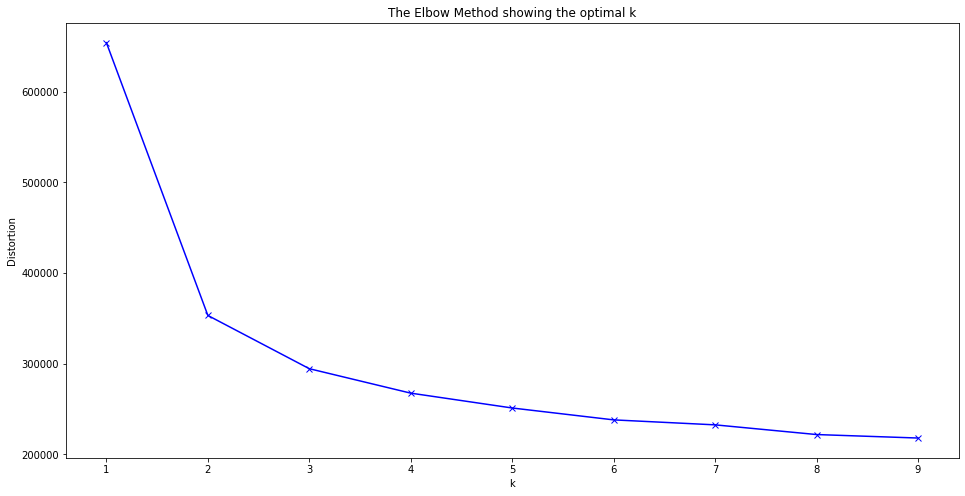

In [30]:
#Using the elbow method on Cosine distance
elbow_method(df_cosine, 10)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

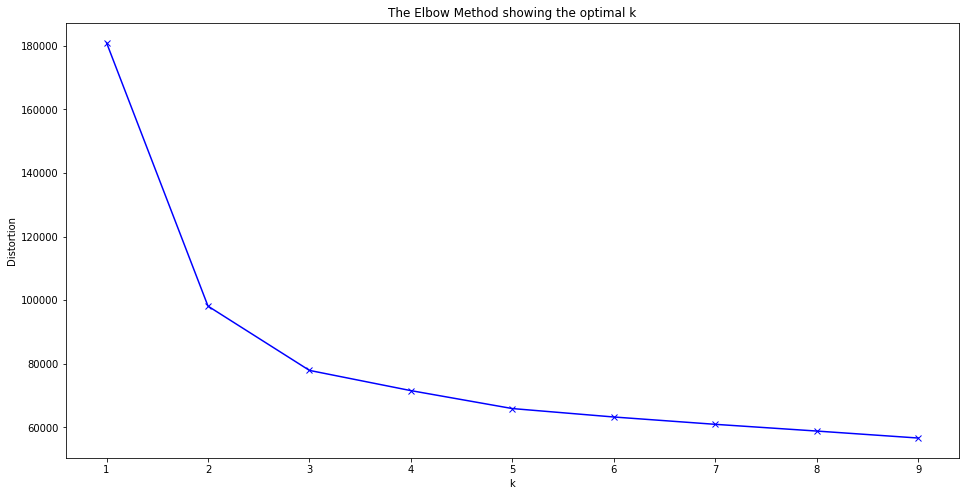

In [31]:
#Using the elbow method on Euclidean distance
elbow_method(Dist_euclidean, 10)

First, we have to modify our df in order to keep the first n users and assign our labels to them

In [32]:
ratings_matrix = ratings_matrix.head(100)
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,17466,17467,17468,17469,17470,17471,17472,17473,17474,17475
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we'll use the PCA method in order to reduce the dimensionality of our matrix and plot our clusters

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# instantiate StandardScaler and PCA with 2 components for 2D scatter plot
scaler = StandardScaler()
pca = PCA(n_components=2)

# fit and transform the ratings matrix
ratings_pca = pca.fit_transform(ratings_matrix)

# print the explained variance ratio for each component
print(pca.explained_variance_ratio_)

[0.04606207 0.02916721]


In [34]:
# create a new dataframe with the PCA components and user index
df_pca = pd.DataFrame(ratings_pca, index=range(0, 100))
df_pca['Cluster'] = labels_euclidean
df_pca

,0,1,Cluster
0,-6.728004,-7.705146,3
1,46.585188,28.504807,0
2,-16.695612,5.261320,1
3,-11.181398,0.679405,2
4,-14.731587,5.683050,2
...,...,...,...
95,-17.206652,5.558100,2
96,-3.741479,-28.909957,3
97,-10.195927,-3.033151,2
98,-7.545602,-4.904089,2


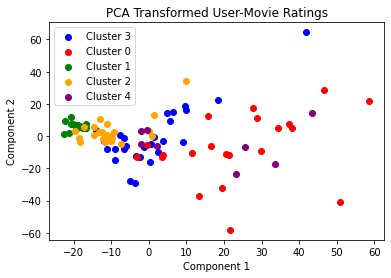

In [35]:
# create a scatter plot of the PCA components
fig, ax = plt.subplots()

for label, color in zip(df_pca['Cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
    group = df_pca.groupby('Cluster').get_group(label)
    ax.scatter(group[0], group[1], c=color, label=f'Cluster {label}')

# set the axis labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('PCA Transformed User-Movie Ratings')

# add a legend
ax.legend()

# show the plot
plt.show()